In [1]:
"""
Name: con_benchmark.ipynb
Authors: Stephan Meighen-Berger
Constructs the benchmark plots to compare with the other models
"""
%load_ext autoreload
%autoreload 2

In [2]:
 # General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from contagion import Contagion, config

In [6]:
# Options
config["average social circle"] = 100
config["variance social circle"] = 1
config['mean social circle interactions'] = 6
config['infected'] = 1
config["population size"] = 100000
config['infection probability mean'] = 3.
config['infection probability variance'] = 2.42
config['hospitalization probability mean'] = 0.5
config['trace spread'] = True

In [7]:
 # Storing the solutions
stats_run = []
t_s_arr = []
seeds = [1337, 1439, 1234, 1343, 3243, 902, 2143, 2334, 10, 8919]
for seed in seeds:
    config["random state"] = np.random.RandomState(seed)
    # Creating a contagion object
    contagion = Contagion()
    contagion.sim()
    stats_run.append(pd.DataFrame(contagion.statistics))
    t_s_arr.append(contagion.trace_infection)

In [8]:
# Averaging stats
stats = {
    'is_recovered': np.average(np.array([stats_run[i]['is_recovered'] for i in range(len(seeds))]), axis=0),
    'is_hospitalized': np.average(np.array([stats_run[i]['is_hospitalized'] for i in range(len(seeds))]), axis=0),
    'is_incubation': np.average(np.array([stats_run[i]['is_incubation'] for i in range(len(seeds))]), axis=0),
    'is_infectious': np.average(np.array([stats_run[i]['is_infectious'] for i in range(len(seeds))]), axis=0),
    'is_latent': np.average(np.array([stats_run[i]['is_latent'] for i in range(len(seeds))]), axis=0),
}
stats = pd.DataFrame(contagion.statistics)
t_s = contagion.trace_infection

In [9]:
# R_eff_steph
r_eff_arr = []
for t_s in t_s_arr:
    edges_inf = np.unique(np.array(np.squeeze(np.hstack([i for i in t_s])).tolist()), axis=0)
    unique, counts = np.unique(edges_inf[:, 0], return_counts=True)
    counter_dic = dict(zip(unique, counts / 2))
    day_to_day_infector = np.array([[i, np.unique(t_s[i][0][:, 0])] for i in range(config["simulation length"])])
    r_eff_arr.append(np.nan_to_num(np.array([
        np.average([counter_dic[day_inf[1][j]] if len(day_inf[1]) > 0 else 0 for j in range(len(day_inf[1]))])
        for day_inf in day_to_day_infector
    ])))
r_eff_steph = np.average(r_eff_arr, axis=0)

C:\Users\steph\Anaconda3\lib\site-packages\numpy\lib\function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\steph\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
newly_recovered = np.diff(stats['is_recovered'])
newly_recovered = np.insert(newly_recovered, 0, 0)

In [11]:
def unique_func(array, orderby='first'):
    array = np.asarray(array)
    order = array.argsort(kind='mergesort')
    array = array[order]
    diff = array[1:] != array[:-1]
    if orderby == 'first':
        diff = np.concatenate([[True], diff])
    elif orderby == 'last':
        diff = np.concatenate([diff, [True]])
    else:
        raise ValueError
    uniq = array[diff]
    index = order[diff]
    return uniq[index.argsort()]

In [12]:
# R_eff_tina
# Need to fix this
# r_eff_arr = []
# for t_s in t_s_arr:
#     edges_inf = np.unique(np.array(np.squeeze(np.hstack([i for i in t_s])).tolist()), axis=0)
#     unique, counts = np.unique(edges_inf[:, 0], return_counts=True)
#     counter_dic = dict(zip(unique, counts / 2))
#     lower_id = 0
#     sorted_infectors = unique_func(np.hstack(np.array([day[0, :,0] for day in t_s])))
#     r_eff_loc = []
#     for i in range(config['simulation length']):
#         today_recovered = newly_recovered[i]
#         upper_id = today_recovered + lower_id
#         todays_recovered_infectors = sorted_infectors[lower_id:upper_id]
#         these_infected = np.sum(np.array([counter_dic[infec] for infec in todays_recovered_infectors]))
#         lower_id = upper_id
#         r_eff_loc.append(np.nan_to_num(these_infected / len(todays_recovered_infectors)))
#     r_eff_arr.append(r_eff_arr)
# r_eff_tina = np.average(r_eff_arr, axis=1)

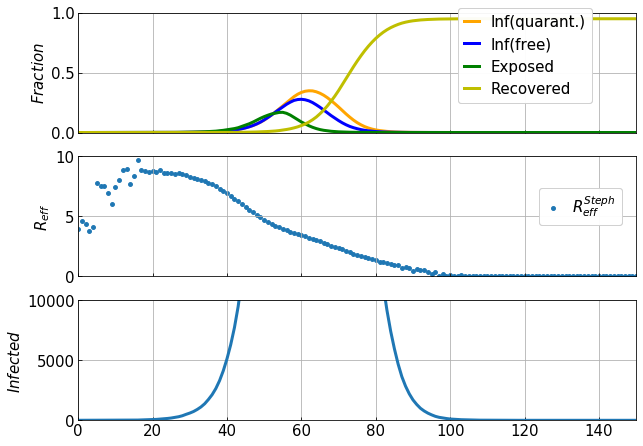

In [13]:
# Plotting standards
std_size = 10.
fontsize = 15.
lw=3.
h_length=1.
figure, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
colors = ['#fdcc8a',
          '#fc8d59',
          '#d7301f']
# ---------------------------------------------------------------------------------
# Infections per time step
ax1.plot(contagion.t, stats['is_hospitalized'] / config['population size'],
         lw=lw, label='Inf(quarant.)', color='orange')
ax1.plot(contagion.t, (stats['is_incubation'] + stats['is_infectious']) / config['population size'],
         lw=lw, label='Inf(free)', color='b')
ax1.plot(contagion.t, (stats['is_latent']) / config['population size'],
         lw=lw, label='Exposed', color="g")
ax1.plot(contagion.t, stats['is_recovered'] / config['population size'],
         lw=lw, label='Recovered', color='y')
# ax1.set_xlim(0, 200)
ax1.set_ylim(0., 1.)
ax1.set_xscale('linear')
ax1.set_yscale('linear')
# ax1.set_xlabel(r't [Days]', fontsize=fontsize)
ax1.set_ylabel(r'$Fraction$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.8, +1.1),
                  ncol=1, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=True)
ax1.add_artist(lgd1)
ax1.grid(True)
# ---------------------------------------------------------------------------------
# The effective R value
ax2.scatter(contagion.t, r_eff_steph, s=lw * 5, label=r'$R_{eff}^{Steph}$')
# ax2.scatter(contagion.t, r_eff_tina, s=lw * 5, label=r'$R_{eff}^{Tina}$')
ax2.set_xlim(0, config['simulation length'])
ax2.set_ylim(0., 10.)
ax2.set_xscale('linear')
ax2.set_yscale('linear')
# ax1.set_xlabel(r't [Days]', fontsize=fontsize)
ax2.set_ylabel(r'$R_{eff}$', fontsize=fontsize)
ax2.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax2.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
h, l = ax2.get_legend_handles_labels()
lgd1 = ax2.legend(h,l, loc=9, bbox_to_anchor=(0.9, +0.8),
                  ncol=1, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=True)
ax2.add_artist(lgd1)
ax2.grid(True)
# ---------------------------------------------------------------------------------
# The number of infected people
ax3.plot(contagion.t, stats['is_infected'], lw=lw)
ax3.set_xlim(0, 150)
ax3.set_ylim(0., 10000)
ax3.set_xscale('linear')
ax3.set_yscale('linear')
# ax1.set_xlabel(r't [Days]', fontsize=fontsize)
ax3.set_ylabel(r'$Infected$', fontsize=fontsize)
ax3.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax3.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax3.grid(True)
plt.show()

In [14]:
figure.savefig(PICS + "Contagion_Benchmark.png",
               bbox_inches='tight')